In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import copy
import matplotlib.pyplot as plt
import seaborn as sns
# pandasの行を省略しない
# pd.set_option('display.max_columns', None)

In [12]:
train_df = pd.read_csv('C:/python/signate/data/train.csv', index_col=0)
test_df = pd.read_csv('C:/python/signate/data/test.csv', index_col=0)
sample_df = pd.read_csv('C:/python/signate/data/sample_submission.csv', header=None, index_col=0)

In [5]:
hist_df = train_df
hist_df['created_at'] = pd.to_datetime(hist_df['created_at'])
hist_df['year'] = hist_df['created_at'].dt.year
hist_df['month'] = hist_df['created_at'].dt.month
hist_df['day'] = hist_df['created_at'].dt.day
hist_df['steward'].fillna('0', inplace=True)
hist_df['guards'].fillna('0', inplace=True)
hist_df['problems'].fillna('0', inplace=True)

test_hits_df = test_df
test_hits_df['created_at'] = pd.to_datetime(test_hits_df['created_at'])
test_hits_df['year'] = test_hits_df['created_at'].dt.year
test_hits_df['month'] = test_hits_df['created_at'].dt.month
test_hits_df['day'] = test_hits_df['created_at'].dt.day
test_hits_df['steward'].fillna('0', inplace=True)
test_hits_df['guards'].fillna('0', inplace=True)
test_hits_df['problems'].fillna('0', inplace=True)

hist_df.head()

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist,year,month,day
0,2015-06-29,14,OnCurb,1,0,0,Damage,Volunteer,0,English oak,...,4152901,Queens,Little Neck,411,11,25,23,2015,6,29
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,0,crimson king maple,...,2039901,Bronx,Bronx,207,33,78,15,2016,9,21
2,2015-09-13,26,OnCurb,2,0,0,NoDamage,Volunteer,StonesBranchLights,English oak,...,5017011,Staten Island,Staten Island,503,24,62,51,2015,9,13
3,2016-05-09,15,OnCurb,0,0,0,Damage,NYC Parks Staff,0,honeylocust,...,5024401,Staten Island,Staten Island,503,24,62,51,2016,5,9
4,2016-06-24,23,OnCurb,1,0,0,NoDamage,Volunteer,Stones,London planetree,...,1022102,Manhattan,New York,110,30,70,9,2016,6,24


In [10]:
print(len(hist_df[hist_df['health'] == 0]))
print(len(hist_df[hist_df['health'] == 1]))
print(len(hist_df[hist_df['health'] == 2]))


3535
15751
698


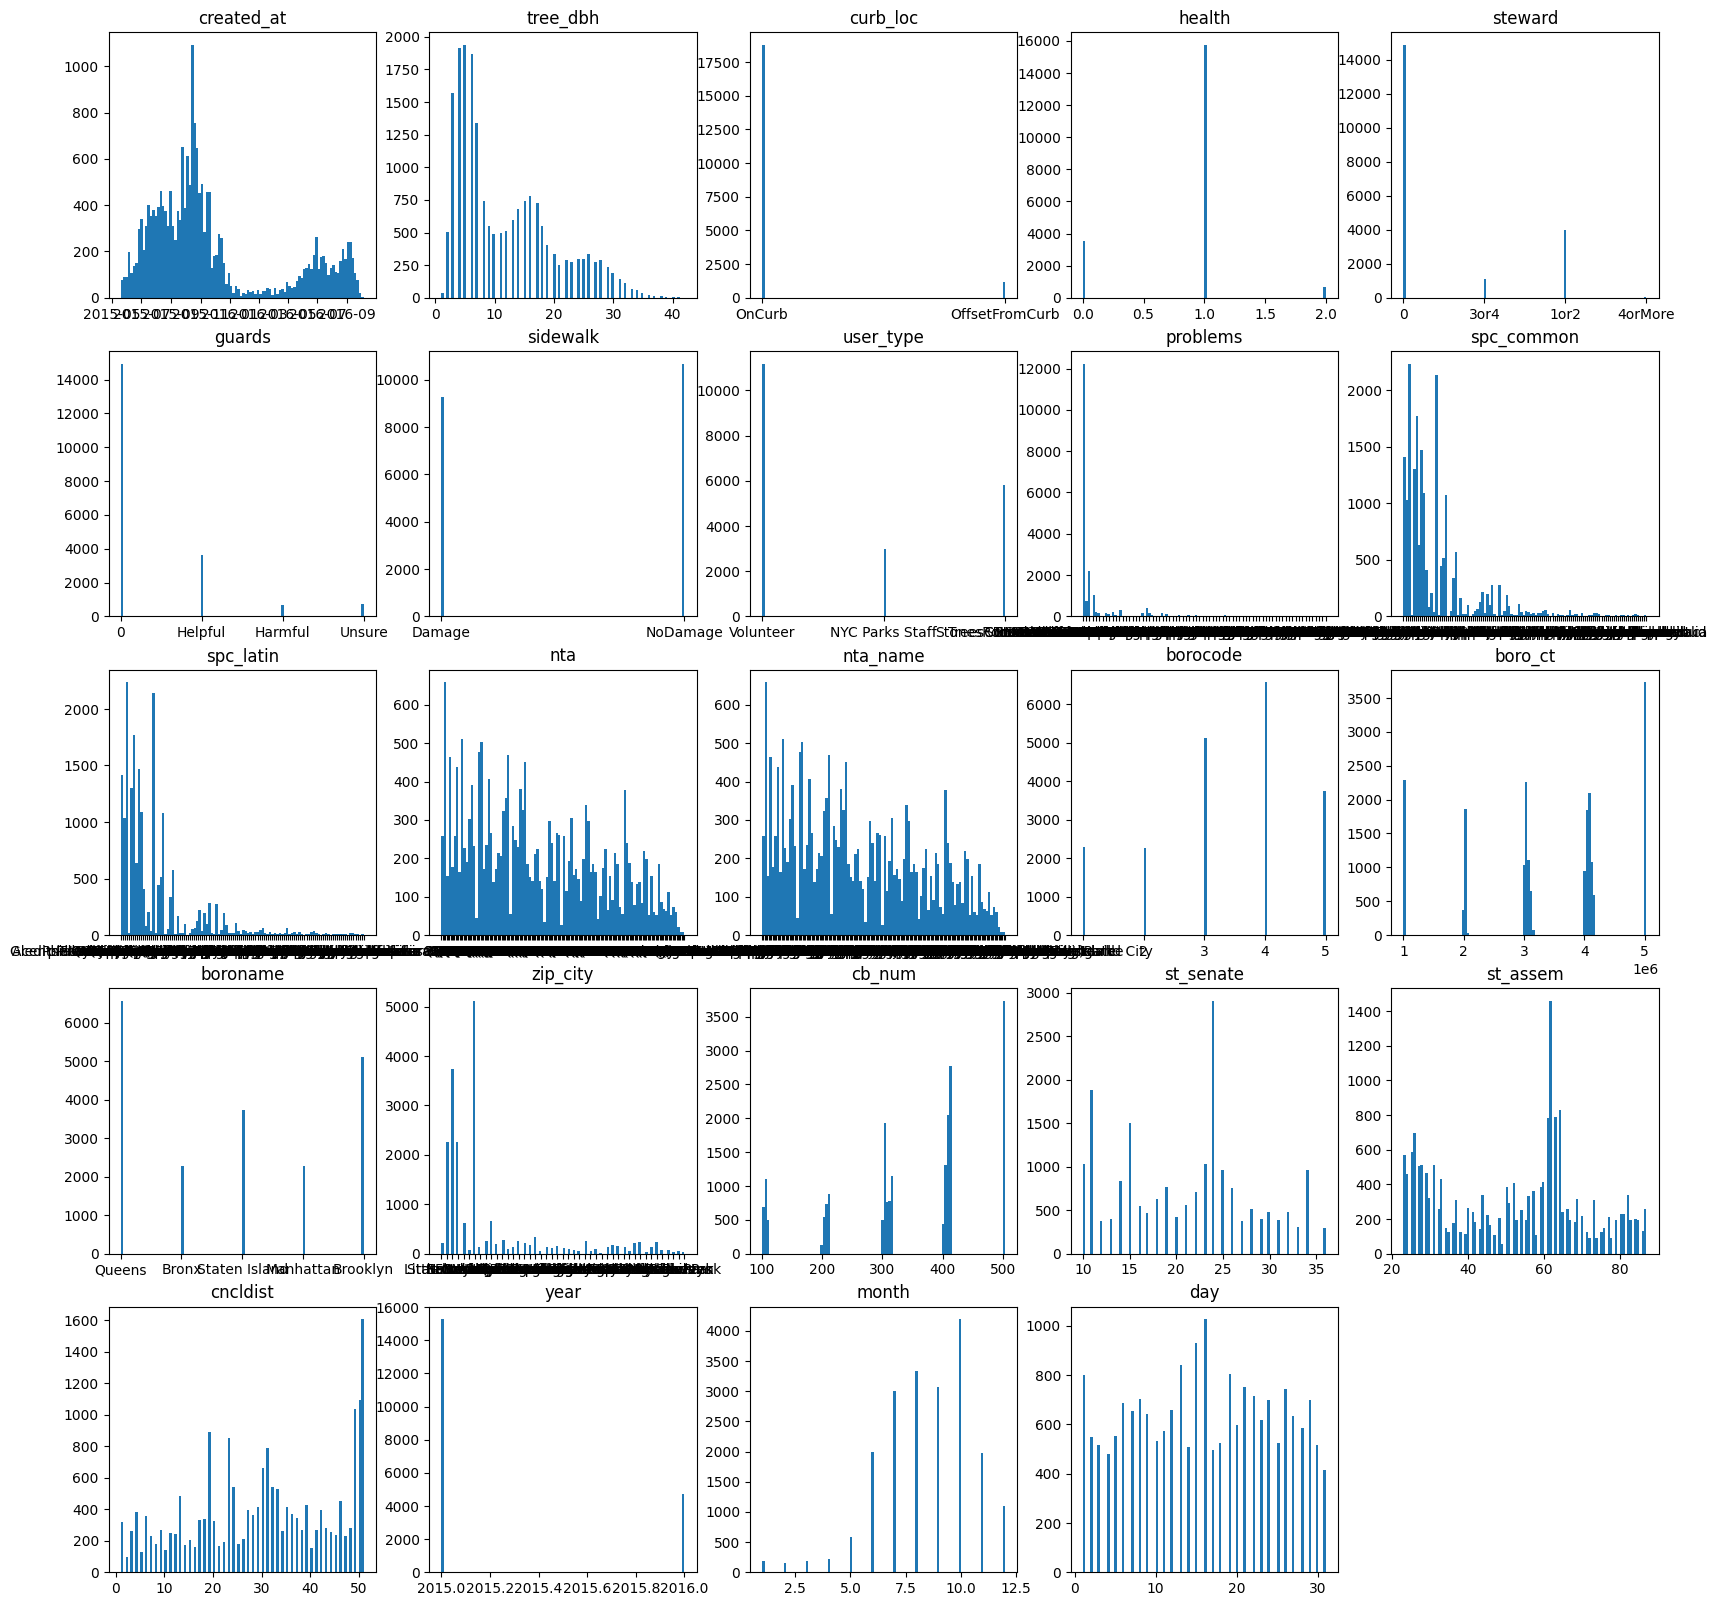

In [32]:
cols = train_df.columns
plt.figure(figsize=(20, 20))
for i, col in enumerate(cols):
    plt.subplot(5, 5, i + 1)
    plt.hist(train_df[col], bins=100)
    plt.title(col)
plt.show()


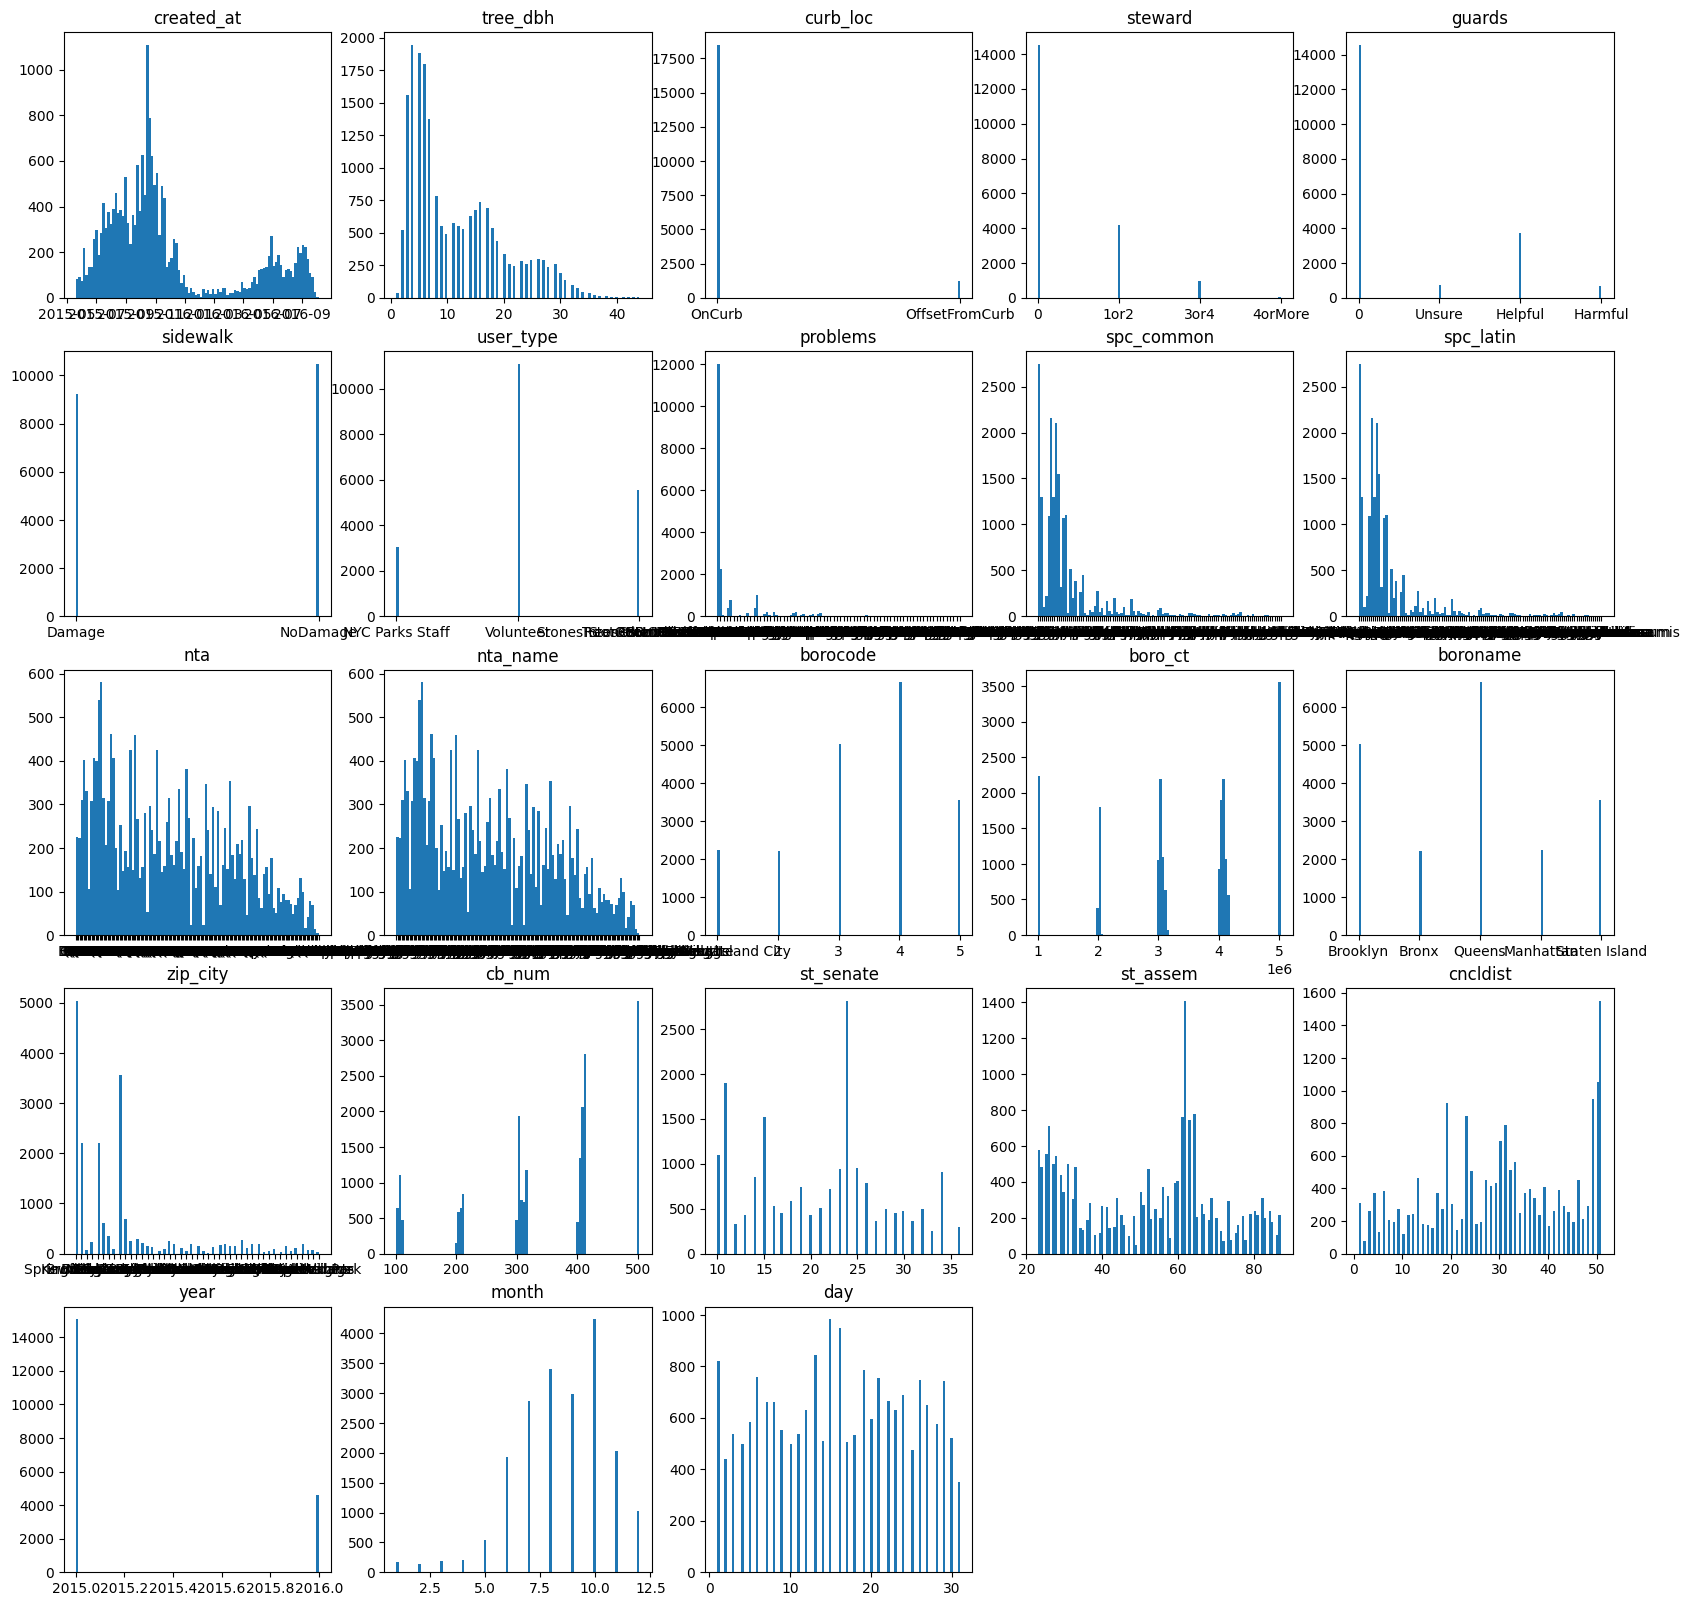

In [33]:
cols = test_df.columns
plt.figure(figsize=(20, 20))
for i, col in enumerate(cols):
    plt.subplot(5, 5, i + 1)
    plt.hist(test_hits_df[col], bins=100)
    plt.title(col)
plt.show()


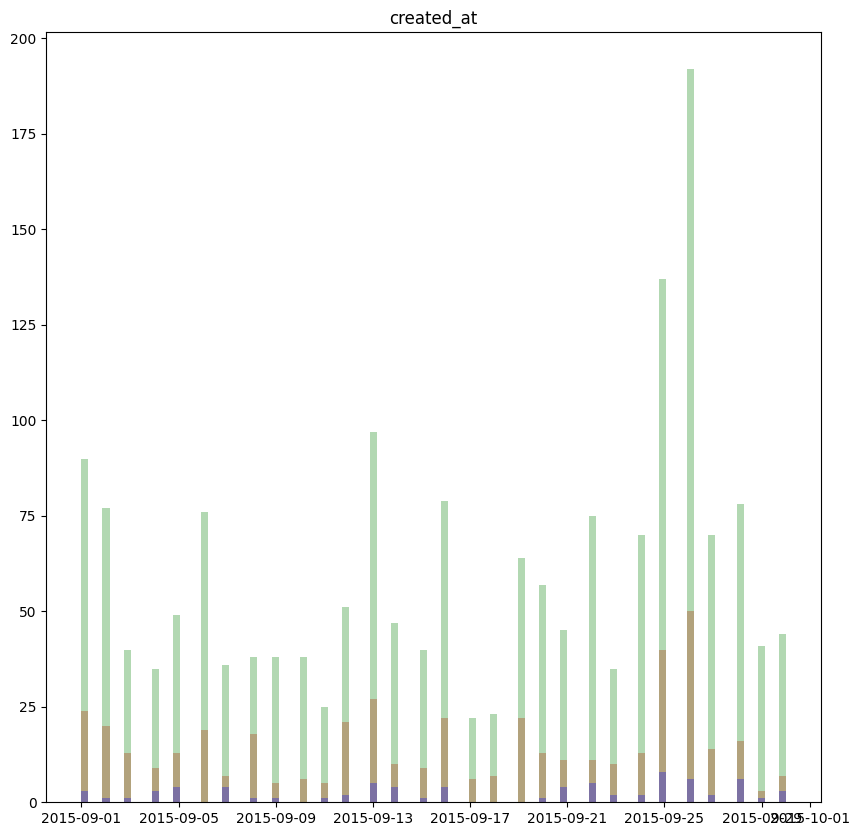

In [13]:
# 2015-09のデータを抽出
tmp_df = hist_df[hist_df['year'] == 2015]
tmp_df = tmp_df[tmp_df['month'] == 9]

col = 'created_at'

plt.figure(figsize=(10, 10))

plt.subplot(1,1,1)
plt.hist(tmp_df[tmp_df['health'] == 0][col], bins=100, alpha=0.3, color='r')
plt.hist(tmp_df[tmp_df['health'] == 1][col], bins=100, alpha=0.3, color='g')
plt.hist(tmp_df[tmp_df['health'] == 2][col], bins=100, alpha=0.3, color='b')
plt.title(col)
plt.show()


In [35]:
# borocodeごとの分布

boro1 = hist_df[hist_df['user_type'] == 'Volunteer']
boro2 = hist_df[hist_df['user_type'] == 'NYC Parks Staff']
boro3 = hist_df[hist_df['user_type'] == 'TreesCount Staff']
boro4 = hist_df[hist_df['borocode'] == 4]
boro5 = hist_df[hist_df['borocode'] == 5]
boro_df_list = [boro1, boro2, boro3, boro4, boro5]


for i in range(3):
    tmp = boro_df_list[i]
    tmp_zero = tmp[tmp['health'] == 0]
    tmp_one = tmp[tmp['health'] == 1]
    tmp_two = tmp[tmp['health'] == 2]
    
    
    print(len(tmp_zero), len(tmp_one), len(tmp_two), len(tmp_zero)/len(tmp),  len(tmp_one)/len(tmp), len(tmp_two)/len(tmp))

2029 8813 347 0.18133881490749842 0.7876485834301546 0.03101260166234695
537 2337 126 0.179 0.779 0.042
969 4601 225 0.16721311475409836 0.7939603106125971 0.03882657463330457


### 各カテゴリと目的変数ごとのヒストグラム

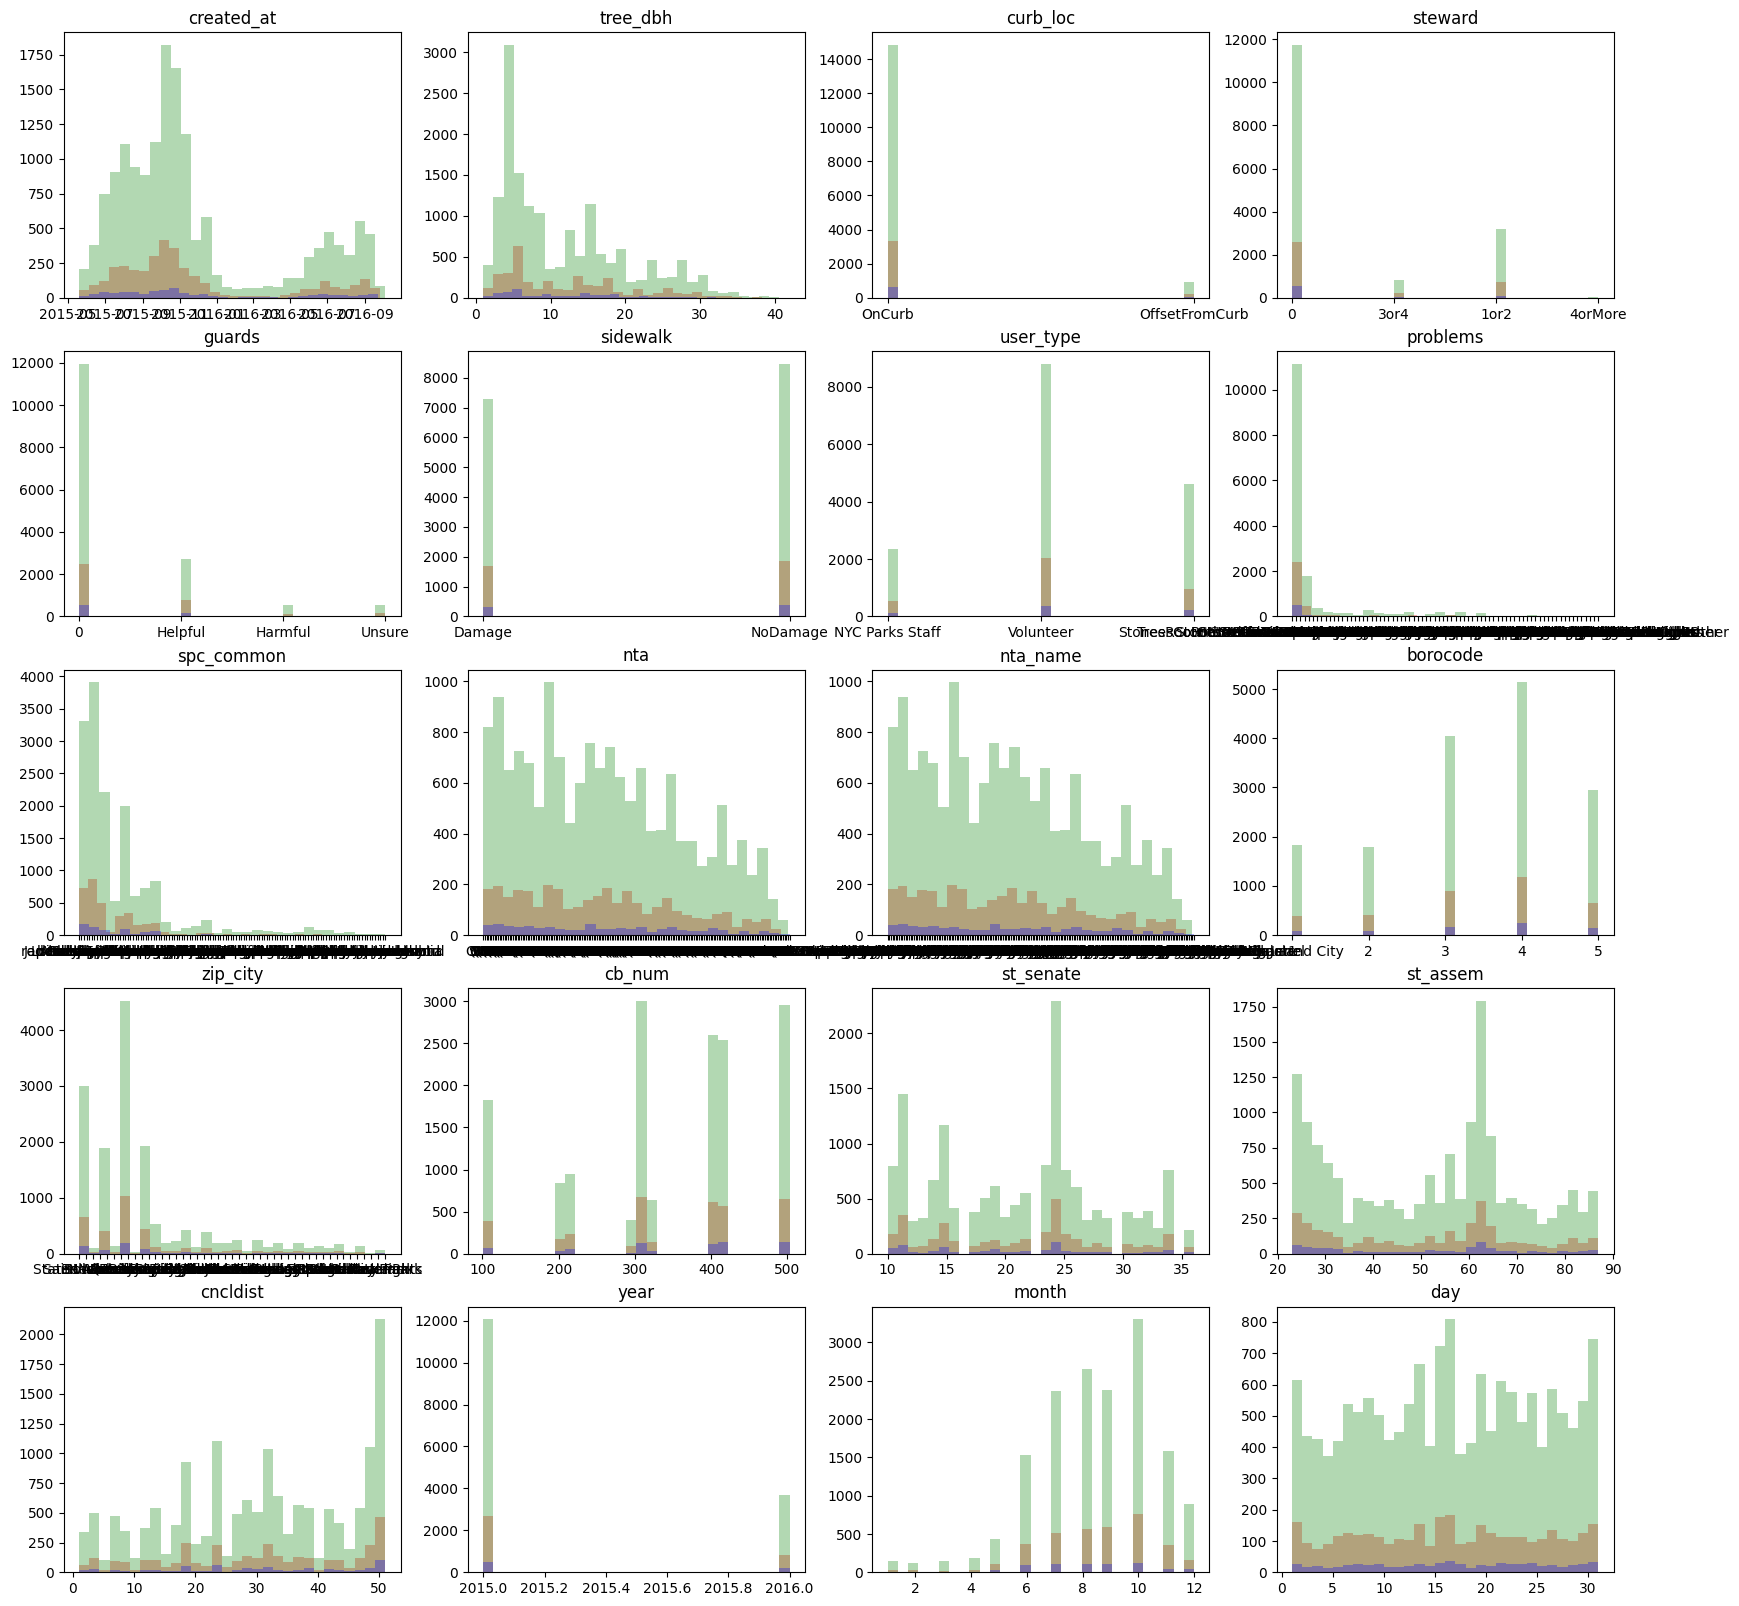

In [37]:
cols = ['created_at', 'tree_dbh', 'curb_loc',  'steward', 'guards',
       'sidewalk', 'user_type', 'problems', 'spc_common', 'nta',
       'nta_name', 'borocode', 'zip_city', 'cb_num',
       'st_senate', 'st_assem', 'cncldist', 'year', 'month', 'day']
plt.figure(figsize=(20, 20))
for i, col in enumerate(cols):
    plt.subplot(5, 4, i + 1)
    plt.hist(train_df[train_df['health'] == 0][col], bins=30, alpha=0.3, color='r')
    plt.hist(train_df[train_df['health'] == 1][col], bins=30, alpha=0.3, color='g')
    plt.hist(train_df[train_df['health'] == 2][col], bins=30, alpha=0.3, color='b')
    plt.title(col)
plt.show()

(array([ 2.,  0., 23.,  0.,  0., 58.,  0., 68.,  0.,  0., 63.,  0., 40.,
         0.,  0., 28.,  0., 28.,  0.,  0., 23.,  0.,  0., 22.,  0., 22.,
         0.,  0., 24.,  0., 27.,  0.,  0., 35.,  0., 29.,  0.,  0., 37.,
         0.,  0., 37.,  0., 24.,  0.,  0., 17.,  0., 10.,  0.,  0.,  5.,
         0., 11.,  0.,  0.,  9.,  0.,  8.,  0.,  0.,  8.,  0.,  0.,  9.,
         0.,  6.,  0.,  0.,  6.,  0.,  6.,  0.,  0.,  3.,  0.,  3.,  0.,
         0.,  2.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.  ,  1.39,  1.78,  2.17,  2.56,  2.95,  3.34,  3.73,  4.12,
         4.51,  4.9 ,  5.29,  5.68,  6.07,  6.46,  6.85,  7.24,  7.63,
         8.02,  8.41,  8.8 ,  9.19,  9.58,  9.97, 10.36, 10.75, 11.14,
        11.53, 11.92, 12.31, 12.7 , 13.09, 13.48, 13.87, 14.26, 14.65,
        15.04, 15.43, 15.82, 16.21, 16.6 , 16.99, 17.38, 17.77, 18.16,
        18.55, 18.94, 19.33, 19.72, 20.11, 20.5 , 20.89, 21.28, 21.67,
        

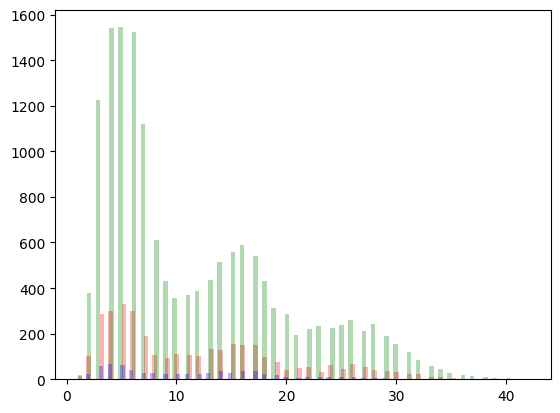

In [38]:
plt.hist(train_df[train_df['health'] == 0]['tree_dbh'], bins=100, alpha=0.3, color='r')
plt.hist(train_df[train_df['health'] == 1]['tree_dbh'], bins=100, alpha=0.3, color='g')
plt.hist(train_df[train_df['health'] == 2]['tree_dbh'], bins=100, alpha=0.3, color='b')

In [39]:
# pandasの行を省略しない
pd.set_option('display.max_rows', None)
train_df.groupby(['zip_city', 'health']).count()[['sidewalk', 'tree_dbh']]

sidewalk  tree_dbh
zip_city            health                    
Arverne             0             11        11
                    1             42        42
                    2              1         1
Astoria             0             25        25
                    1            134       134
                    2              2         2
Bayside             0             42        42
                    1            163       163
                    2             13        13
Bellerose           0             26        26
                    1            107       107
                    2              8         8
Bronx               0            407       407
                    1           1786      1786
                    2             77        77
Brooklyn            0            901       901
                    1           4054      4054
                    2            164       164
Cambria Heights     0             16        16
                    1             74        74
                    2              1         1
Central Park        0              1         1
                    1             18        18
                    2              2         2
College Point       0             27        27
                    1            101       101
                    2              7         7
Corona              0              7         7
                    1             55        55
                    2              1         1
East Elmhurst       0             21        21
                    1            118       118
                    2              4         4
Elmhurst            0             28        28
                    1             76        76
Far Rockaway        0             30        30
                    1            202       202
                    2              9         9
Floral Park         0              5         5
                    1             26        26
                    2              2         2
Flushing            0            125       125
                    1            469       469
                    2             21        21
Forest Hills        0             42        42
                    1            197       197
                    2              9         9
Fresh Meadows       0             34        34
                    1            187       187
                    2              5         5
Glen Oaks           0             21        21
                    1             99        99
                    2              8         8
Hollis              0             10        10
                    1             52        52
                    2              3         3
Howard Beach        0             29        29
                    1            141       141
                    2              8         8
Jackson Heights     0             10        10
                    1             35        35
                    2              2         2
Jamaica             0            115       115
                    1            522       522
                    2             23        23
Kew Gardens         0             12        12
                    1             56        56
Little Neck         0             36        36
                    1            171       171
                    2             15        15
Long Island City    0             19        19
                    1             89        89
                    2              6         6
Maspeth             0             24        24
                    1             99        99
                    2              6         6
Middle Village      0             38        38
                    1            165       165
                    2             10        10
New York            0            391       391
                    1           1805      1805
                    2             71        71
Oakland Gardens     0             47        47
                    1            

In [40]:
pd.set_option('display.max_rows', None)
display(pd.DataFrame(train_df.groupby(['health', 'problems']).count()['nta']))

problem_words = ['BranchLights', 'BranchOther', 'MetalGrates', 'RootOther', 'Stones', 'Sneakers', 'TrunkLights',
                 'TrunkOther', 'WiresRope']	

nta
health problems                                                
0      0                                                   2020
       BranchLights                                         206
       BranchLightsBranchOther                                4
       BranchOther                                           77
       MetalGrates                                           16
       MetalGratesBranchOther                                 7
       MetalGratesRootOtherBranchOther                        6
       MetalGratesRootOtherTrunkOther                         7
       MetalGratesTrunkOther                                  3
       MetalGratesTrunkOtherBranchOther                       3
       MetalGratesWiresRope                                   3
       RootOther                                             63
       RootOtherBranchLights                                 10
       RootOtherBranchLightsBranchOther                       2
       RootOtherBranchOther                                  12
       RootOtherTrunkLightsBranchOther                        7
       RootOtherTrunkOther                                   16
       RootOtherTrunkOtherBranchLights                        7
       RootOtherTrunkOtherBranchLightsBranchOther             4
       RootOtherTrunkOtherBranchOther                        29
       RootOtherWiresRope                                     8
       RootOtherWiresRopeBranchLights                         1
       RootOtherWiresRopeBranchLightsBranchOther              8
       RootOtherWiresRopeBranchOther                          2
       RootOtherWiresRopeTrunkLights                          1
       RootOtherWiresRopeTrunkOther                           7
       RootOtherWiresRopeTrunkOtherBranchLights               3
       RootOtherWiresRopeTrunkOtherBranchOther                3
       Stones                                               441
       StonesBranchLights                                   171
       StonesBranchLightsBranchOther                          7
       StonesBranchOther                                     35
       StonesMetalGrates                                      2
       StonesMetalGratesBranchLights                          4
       StonesMetalGratesWiresRopeTrunkLightsBranchLights      2
       StonesRootOther                                       35
       StonesRootOtherBranchLightsBranchOther                 2
       StonesRootOtherBranchOther                            10
       StonesRootOtherTrunkOther                             18
       StonesRootOtherTrunkOtherBranchLights                  7
       StonesRootOtherTrunkOtherBranchOther                   1
       StonesRootOtherWiresRopeBranchLights                  14
       StonesRootOtherWiresRopeBranchOther                    2
       StonesRootOtherWiresRopeTrunkOtherBranchLightsB...     3
       StonesSneakers                                         2
       StonesTrunkOther                                      38
       StonesTrunkOtherBranchLights                           5
       StonesTrunkOtherBranchLightsBranchOther                1
       StonesTrunkOtherBranchOther                           13
       StonesWiresRope                                        3
       StonesWiresRopeBranchLights                           32
       StonesWiresRopeBranchLightsBranchOther                 5
       StonesWiresRopeBranchOther                             3
       StonesWiresRopeTrunkLightsBranchLights                 4
       StonesWiresRopeTrunkOther                              1
       StonesWiresRopeTrunkOtherBranchLights                  4
       TrunkLights                                            4
       TrunkLightsBranchLights                                7
       TrunkOther                                            37
       TrunkOtherBranchLights                                 7
       TrunkOtherBranchLightsBranchOther                      3
       TrunkOtherBranchOther

### problemsめちゃくちゃあると思ったら、大文字ごとの要素の組み合わせだった

In [41]:
import re
def str_split(string):
    big_ite = re.findall(r'[A-Z][a-z]+', string)
    return big_ite

tmp = str_split('MetalGratesBranchOther')
tmp

['Metal', 'Grates', 'Branch', 'Other']

### problemは11種類の組み合わせにすぎない

In [42]:
word_list = []
for problem in train_df['problems']:
    tmp = str_split(problem)
    for word in tmp:
        if(word not in word_list):
            word_list.append(word)

In [43]:
print(len(word_list))
print((word_list))


11
['Stones', 'Branch', 'Lights', 'Trunk', 'Other', 'Wires', 'Rope', 'Metal', 'Grates', 'Root', 'Sneakers']


In [44]:
train_df.groupby(['spc_common', 'spc_latin']).count()[['boroname', 'problems']]

,,boroname,problems
spc_common,spc_latin,,
'Schubert' chokecherry,Prunus virginiana,98,98
American beech,Fagus grandifolia,7,7
American elm,Ulmus americana,407,407
American hophornbeam,Ostrya virginiana,22,22
American hornbeam,Carpinus caroliniana,25,25
American linden,Tilia americana,336,336
Amur cork tree,Phellodendron amurense,15,15
Amur maackia,Maackia amurensis,33,33
Amur maple,Acer ginnala,52,52
